In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Models ##

In [2]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

class BERT(nn.Module):
    """
    A model based on BERT.

    Attributes:
        bert (BertModel): The BERT model used for encoding input text.
    """
    def __init__(self, bert_model_name):
        super(BERT, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the BERT classifier.

        Args:
            input_ids (torch.Tensor): Tensor of token IDs.
            attention_mask (torch.Tensor): Tensor indicating which tokens are real words (1) and which are padding (0).

        Returns:
            torch.Tensor: Logits for each class.
        """
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output

        return pooled_output

class MLP(nn.Module):
    """
    A multi-layer perceptron (MLP) for classification.

    Attributes:
        dropout (nn.Dropout): Dropout layer for regularization.
        classifier (nn.Sequential): A multi-layer perceptron (MLP) for classification.
    """
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, input_dim//2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(input_dim//2, num_classes),
        )

    def forward(self, x):
        """
        Forward pass of the MLP.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Logits for each class.
        """
        x = self.dropout(x)
        logits = self.classifier(x)
        return logits


class BERTClassifier(nn.Module):
    """
    A combined model using BERT for encoding and MLP for classification.

    Attributes:
        bert (BERT): The BERT model for encoding text.
        mlp (MLP): The MLP for classification.
    """
    def __init__(self, bert_encoder, classifier, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert_encoder = bert_encoder
        self.classifier = classifier

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the combined BERT and MLP classifier.

        Args:
            input_ids (torch.Tensor): Tensor of token IDs.
            attention_mask (torch.Tensor): Tensor indicating which tokens are real words (1) and which are padding (0).

        Returns:
            torch.Tensor: Logits for each class.
        """
        pooled_output = self.bert_encoder(input_ids, attention_mask)
        logits = self.classifier(pooled_output)
        return logits

condi_to_unfreeze = ["fc", "pooler", "layer.5"]

def freeze_layers_by_name(model, unfreeze_condi_in_name=[]):
  for param, (name, _) in zip(model.parameters(), model.state_dict().items()):
      if any([condi in name for condi in unfreeze_condi_in_name]):
        param.requires_grad = True
      else:
        param.requires_grad = False
  return model

def show_model_state(model):
  for param, (name, _) in zip(model.parameters(), model.state_dict().items()):
    print(name, " : ", param.requires_grad)

## Dataset ##

In [3]:
import torch
import numpy as np
from torch.utils.data import Dataset

class TextClassificationDataset(Dataset):
    """
    A dataset class for text classification tasks.

    Attributes:
        texts (list): List of text samples.
        labels (list): List of labels corresponding to each text sample.
        tokenizer (Tokenizer): Tokenizer to convert text to input IDs and attention masks.
        max_length (int): Maximum length of tokenized sequences.
    """
    def __init__(self, df, tokenizer, label_encodeur, max_length):
        """
        Initializes the dataset with texts, labels, tokenizer, and maximum sequence length.

        Args:
            texts (list): List of text samples.
            labels (list): List of labels.
            tokenizer (Tokenizer): Tokenizer to preprocess the texts.
            max_length (int): Maximum length for the tokenized sequences.
        """
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_encodeur = label_encodeur

    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns:
            int: Number of samples.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Returns the tokenized inputs and label for a given index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: A dictionary containing input IDs, attention mask, and label.
        """
        row = self.df.iloc[idx]
        text = row["CleanDescription"]
        label = row["ProductCode"]

        encoding = self.tokenizer(
            text,
            return_tensors='pt',
            max_length=self.max_length,
            padding='max_length',
            truncation=True
        )

        label = self.label_encodeur.transform(np.array([label]).reshape(-1, 1)).toarray()

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float).flatten()
        }

## Train ##

In [4]:
from sklearn.metrics import accuracy_score, classification_report

def train(model, train_loader, val_loader, optimizer, scheduler, device, loss, num_epochs):
    """
    Train the model for multiple epochs with validation.

    Args:
        model (nn.Module): The model to be trained.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
        optimizer (torch.optim.Optimizer): Optimizer for updating the model's weights.
        scheduler (torch.optim.lr_scheduler): Learning rate scheduler.
        device (torch.device): Device to perform training on (CPU or GPU).
        num_epochs (int): Number of epochs to train the model.

    Returns:
        list, list: Lists of training and validation losses.
    """
    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses
    val_accuracies = []  # List to store validation accuracies

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0.0  # Initialize epoch training loss

        # Training loop
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # print(outputs.shape)
            # print(labels.shape)

            # print(outputs[0])
            # print(labels[0])

            computed_loss = loss(outputs, labels)
            computed_loss.backward()

            optimizer.step()
            scheduler.step()

            epoch_train_loss += computed_loss.item() * input_ids.size(0)

        # Calculate average training loss for the epoch
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0.0  # Initialize epoch validation loss
        val_predictions = []  # List to store validation predictions
        val_actual_labels = []  # List to store validation actual labels

        with torch.no_grad():
            for val_batch in val_loader:
                input_ids = val_batch['input_ids'].to(device)
                attention_mask = val_batch['attention_mask'].to(device)
                labels = val_batch['label'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)

                val_loss = loss(outputs, labels)

                epoch_val_loss += val_loss.item() * input_ids.size(0)

                # Get validation predictions and actual labels
                _, preds = torch.max(outputs, dim=1)
                _, labels = torch.max(labels, dim=1)

                val_predictions.extend(preds.cpu().tolist())
                val_actual_labels.extend(labels.cpu().tolist())

        # Calculate average validation loss for the epoch
        epoch_val_loss /= len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        # print(val_actual_labels)
        # print(val_predictions)

        # Calculate validation accuracy for the epoch
        val_accuracy = accuracy_score(val_actual_labels, val_predictions)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}: "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, val_accuracies


def evaluate(model, data_loader, device):
    """
    Evaluate the model on the validation/test dataset.

    Args:
        model (nn.Module): The model to be evaluated.
        data_loader (DataLoader): DataLoader for the validation/test data.
        device (torch.device): Device to perform evaluation on (CPU or GPU).

    Returns:
        tuple: Accuracy score and classification report.
    """
    # Set the model to evaluation mode
    model.eval()

    # Lists to store predictions and actual labels
    predictions = []
    actual_labels = []

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        # Loop over batches of data from the DataLoader
        for batch in data_loader:
            # Move input data to the specified device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass: compute the model output
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Get the predicted class by finding the index with the maximum score
            _, preds = torch.max(outputs, dim=1)

            # Store predictions and actual labels
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    # Calculate accuracy and classification report
    accuracy = accuracy_score(actual_labels, predictions)
    report = classification_report(actual_labels, predictions)

    return accuracy, report

## Data settings ##


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def load_train_test_data(train_path, test_path, used_columns):

    split_ratio = 0.8
    train_base = pd.read_excel(train_path)
    test_base = pd.read_excel(test_path)

    train_base = train_base.dropna(axis=0, subset=used_columns)
    test_base = test_base.dropna(axis=0, subset=used_columns)

    for c in used_columns:
        print(c, "null rows : ", len(train_base[train_base[c].isnull()]))

    for c in used_columns:
        print(c, "null rows : ", len(test_base[test_base[c].isnull()]))

    return train_base, test_base


def filter_productcode(train, test, MIN_ROW=50, MAX_ROW=50, seed=4, split_ratio=0.8):

    def _res_max_df(df, max_selected_productcodes, max_row):
      df1 = df[~df["ProductCode"].isin(max_selected_productcodes.index)]
      added_df = [df1]
      for code in max_selected_productcodes.index.tolist():
        code_df = df[df["ProductCode"]==code]
        if len(code_df)>=max_row:
          added_df.append(code_df.sample(n=max_row, random_state=seed))

      return pd.concat(added_df)

    count = train.ProductCode.value_counts()

    # Process min_row
    min_selected_productcodes = count[count>=MIN_ROW]

    train = train[train["ProductCode"].isin(min_selected_productcodes.index)]
    test = test[test["ProductCode"].isin(min_selected_productcodes.index)]

    # Process max_row
    max_selected_productcodes_train = count[count>=MAX_ROW]
    train = _res_max_df(train, max_selected_productcodes_train, MAX_ROW)

    count = test.ProductCode.value_counts()
    max_selected_productcodes_test = count[count>=int(MAX_ROW*(1-split_ratio))]
    test = _res_max_df(test, max_selected_productcodes_test, int(MAX_ROW*(1-split_ratio)))

    print(f"Train contient {len(train)} lignes")
    print(f"Test contient {len(test)} lignes")

    # Check train pc containing test pc
    train_pc = train.ProductCode.unique()
    test_pc = test.ProductCode.unique()
    if set(test_pc).issubset(set(train_pc)):
        print("Train pc contient test")

    return train, test

def get_pc_info(df):
    count = df.ProductCode.value_counts()
    print(f"Il y a {len(count)} codes produits traités")

    print("La distribution des codes produit est :\n")
    plt.figure(figsize=(70,20))
    count.plot(kind='bar')
    plt.show()

    return count

In [6]:
split_ratio = 0.8

train_path = r"/content/drive/MyDrive/Data/PAC/Global_data/train_cleanDescription.xlsx"
test_path = r"/content/drive/MyDrive/Data/PAC/Global_data/test_cleanDescription.xlsx"

used_columns = ["CleanDescription", "AccountCode", "Laboratory", "ProductCode"]

train_base, test_base = load_train_test_data(train_path, test_path, used_columns)

CleanDescription null rows :  0
AccountCode null rows :  0
Laboratory null rows :  0
ProductCode null rows :  0
CleanDescription null rows :  0
AccountCode null rows :  0
Laboratory null rows :  0
ProductCode null rows :  0


In [7]:
train_df, test_df = filter_productcode(train_base, test_base, MIN_ROW=20, MAX_ROW=200, seed=4, split_ratio=split_ratio)

Train contient 26269 lignes
Test contient 6261 lignes
Train pc contient test


Il y a 445 codes produits traités
La distribution des codes produit est :



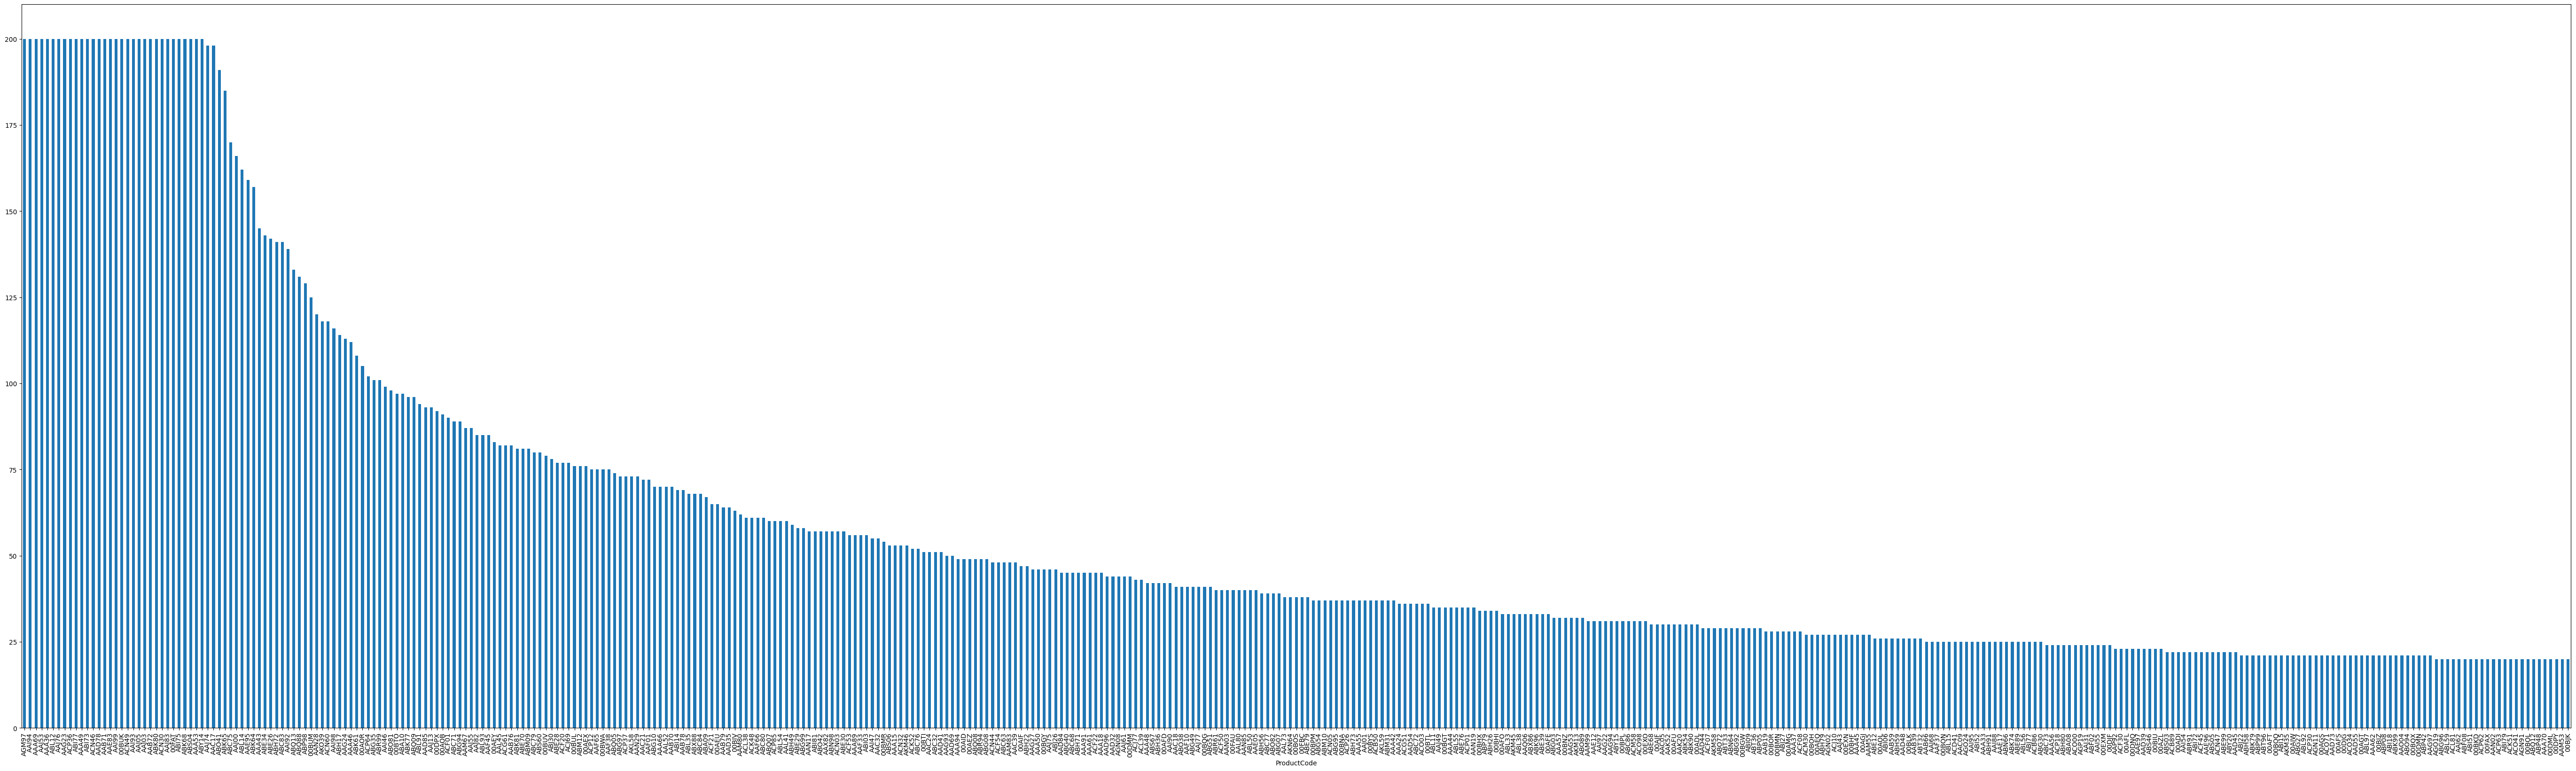

ProductCode
AGM97    200
AAI94    200
AAA69    200
AAJ53    200
AAA36    200
        ... 
AAA70     20
00DML     20
00DPY     20
AAM53     20
00BJK     20
Name: count, Length: 445, dtype: int64

In [8]:
get_pc_info(train_df)

## Training settings ##

In [9]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def encode_target_variable(train_df, test_df=None):
    """
    Encode the target variable in the training dataset and optionally encode the target variable in the test dataset
    using the encoder trained on the training dataset.

    Args:
    train_df (DataFrame): Training dataset containing the target variable "ProductCode".
    test_df (DataFrame, optional): Test dataset containing the target variable "ProductCode". Defaults to None.

    Returns:
    tuple: A tuple containing the encoder trained on the training dataset and the encoded target variable for
           the training dataset. If test dataset is provided, also returns the encoded target variable for the test dataset.
    """
    # Initialize LabelEncoder
    label_encoder = OneHotEncoder()

    # Fit and transform the target variable in the training dataset
    train_target_encoded = label_encoder.fit_transform(np.array(train_df["ProductCode"]).reshape(-1, 1))

    # If test dataset is provided, transform the target variable using the encoder trained on the training dataset
    if test_df is not None:
        test_target_encoded = label_encoder.transform(np.array(test_df["ProductCode"]).reshape(-1, 1))
        return label_encoder, train_target_encoded, test_target_encoded

    return label_encoder, train_target_encoded

In [10]:
# Set up parameters
from torch.utils.data import DataLoader
from torch.optim import AdamW

label_encoder, train_target_encoded = encode_target_variable(train_df, test_df=None)

bert_model_name = 'bert-base-uncased'
max_length = 128
TEXT_DIM = 768

num_classes = len(train_df.ProductCode.value_counts())

batch_size = 16
num_epochs = 13
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained(bert_model_name)
text_encoder = BERT(bert_model_name)
freeze_layers_by_name(text_encoder, unfreeze_condi_in_name=[])
mlp = MLP(input_dim=TEXT_DIM, num_classes=num_classes)
model = BERTClassifier(bert_encoder=text_encoder, classifier=mlp, num_classes=num_classes)
model.to(device)

show_model_state(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

bert_encoder.bert.embeddings.word_embeddings.weight  :  False
bert_encoder.bert.embeddings.position_embeddings.weight  :  False
bert_encoder.bert.embeddings.token_type_embeddings.weight  :  False
bert_encoder.bert.embeddings.LayerNorm.weight  :  False
bert_encoder.bert.embeddings.LayerNorm.bias  :  False
bert_encoder.bert.encoder.layer.0.attention.self.query.weight  :  False
bert_encoder.bert.encoder.layer.0.attention.self.query.bias  :  False
bert_encoder.bert.encoder.layer.0.attention.self.key.weight  :  False
bert_encoder.bert.encoder.layer.0.attention.self.key.bias  :  False
bert_encoder.bert.encoder.layer.0.attention.self.value.weight  :  False
bert_encoder.bert.encoder.layer.0.attention.self.value.bias  :  False
bert_encoder.bert.encoder.layer.0.attention.output.dense.weight  :  False
bert_encoder.bert.encoder.layer.0.attention.output.dense.bias  :  False
bert_encoder.bert.encoder.layer.0.attention.output.LayerNorm.weight  :  False
bert_encoder.bert.encoder.layer.0.attention.outp

In [11]:
model

BERTClassifier(
  (bert_encoder): BERT(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
  

In [12]:
train_dataset = TextClassificationDataset(train_df, tokenizer, label_encoder, max_length)
test_dataset = TextClassificationDataset(test_df, tokenizer, label_encoder, max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss = nn.CrossEntropyLoss()

In [13]:
for batch in train_loader:
    print(batch)
    break

{'input_ids': tensor([[  101, 12884,  7099,  ...,     0,     0,     0],
        [  101,  6986,  2063,  ...,     0,     0,     0],
        [  101, 15544, 18376,  ...,     0,     0,     0],
        ...,
        [  101,  1048,  2015,  ...,     0,     0,     0],
        [  101, 16985,  9834,  ...,     0,     0,     0],
        [  101, 26572,  3207,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'label': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])}


In [ ]:
train(model, train_loader, test_loader, optimizer, scheduler, device, loss, num_epochs)